In [1]:
import numpy as np
import tensorflow as tf

In [7]:
data_dir = '../'

with np.load(data_dir+'\\T0l.npz') as eletr_score:
    for item in eletr_score.files:
        T0l = eletr_score[item]
with np.load(data_dir+'\\T1l.npz') as data_xS:
    for item in data_xS.files:
        T1l = data_xS[item]
with np.load(data_dir+'\\T2l.npz') as data_xS:
    for item in data_xS.files:
        T2l = data_xS[item]

print('Dataset .npz encontrado!')

Dataset .npz encontrado!


In [9]:
tam_data = 721

x1 = [T1l[:,i:i+tam_data] for i in range(0,len(T1l[0]),tam_data) if i+tam_data < len(T1l[0])]
x2 = [T2l[:,i:i+tam_data] for i in range(0,len(T2l[0]),tam_data) if i+tam_data < len(T2l[0])]
x1 = np.array(x1); x2 = np.array(x2)
print(x1.shape, x2.shape)

(326, 16, 721) (321, 16, 721)


In [10]:
x = np.concatenate((x1,x2),axis=0)
y = [0 for i in x1] + [1 for i in x2]
y = np.array(y)

print(f'{len(x1)} + {len(x2)} = {len(x1)+len(x2)}')
print(f'Tamanho de x: {x.shape}')

326 + 321 = 647
Tamanho de x: (647, 16, 721)


In [11]:
from sklearn.utils import shuffle
x, y = shuffle(x,y,random_state=0)

In [12]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.10)

In [15]:
import keras
from keras_tuner import HyperModel
from keras.utils import to_categorical
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout
from tensorflow import keras

In [17]:
help(Conv1D)

Help on class Conv1D in module keras.src.layers.convolutional.conv1d:

class Conv1D(keras.src.layers.convolutional.base_conv.BaseConv)
 |  Conv1D(filters, kernel_size, strides=1, padding='valid', data_format=None, dilation_rate=1, groups=1, activation=None, use_bias=True, kernel_initializer='glorot_uniform', bias_initializer='zeros', kernel_regularizer=None, bias_regularizer=None, activity_regularizer=None, kernel_constraint=None, bias_constraint=None, **kwargs)
 |
 |  1D convolution layer (e.g. temporal convolution).
 |
 |  This layer creates a convolution kernel that is convolved with the layer
 |  input over a single spatial (or temporal) dimension to produce a tensor of
 |  outputs. If `use_bias` is True, a bias vector is created and added to the
 |  outputs. Finally, if `activation` is not `None`, it is applied to the
 |  outputs as well.
 |
 |  Args:
 |      filters: int, the dimension of the output space (the number of filters
 |          in the convolution).
 |      kernel_size

In [ ]:
model = Sequential()

model.add(Conv1D(filters=20, kernel_size=(3,), activation='relu'))
model.add(Conv1D(filters=20, kernel_size=(6,), activation='relu'))
model.add(MaxPooling1D(pool_size=(2,)))
model.add(Flatten())
model.add(Dense(units=60, activation='relu'))
model.add(Dense(units=1, activation='sigmoid'))
model.compile(loss='binary_crossentropy')

hist = model.fit(x_train,y_train, epochs=10,validation_data=(x_test,y_test))

Epoch 1/10


ValueError: Could not interpret loss identifier: accuracy

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


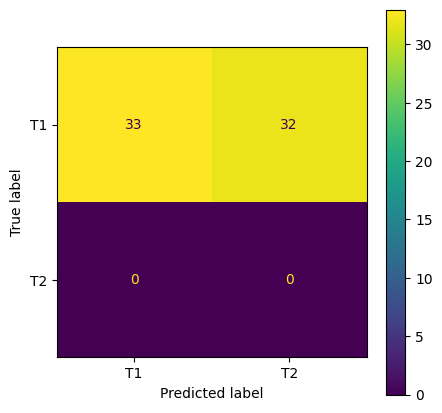

In [24]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import matplotlib.pyplot as plt

#Make predictions
y_probs = model.predict(x_test)
#Convert prediction probabilities into integers
y_preds = y_probs.argmax(axis=1)
#Confusion matrix
cm=confusion_matrix(y_preds,y_test)
#
label_names = ["T1","T2"]
disp=ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=label_names)
fig, ax = plt.subplots(figsize=(5,5))
disp.plot(ax=ax)

In [105]:

METRICS = [
        keras.metrics.TruePositives(name='tp'),
        keras.metrics.FalsePositives(name='fp'),
        keras.metrics.TrueNegatives(name='tn'),
        keras.metrics.FalseNegatives(name='fn'),
        keras.metrics.BinaryAccuracy(name='accuracy'),
        keras.metrics.Precision(name='precision'),
        keras.metrics.Recall(name='recall'),
        keras.metrics.AUC(name='auc'),
    ]
class CNNHyperModel(HyperModel):
    def __init__(self, input_shape, num_classes):
        self.input_shape = input_shape
        self.num_classes = num_classes

    def build(self, hp):
        model = keras.Sequential()
        
        model.add(
            Conv1D(
                filters=hp.Int('filters', min_value=20, max_value=60, step=10, default=40),
                kernel_size=hp.Int('kernel_size', min_value=2, max_value=10, step=2, default=4),  
                activation='relu',
                input_shape=self.input_shape
            )
        )
        
        model.add(
            Conv1D(
                filters=hp.Int('filters', min_value=20, max_value=60, step=10, default=40),
                kernel_size=hp.Int('kernel_size', min_value=2, max_value=10, step=2, default=4),  
                activation='relu'
            )
        )
        
        model.add(
            MaxPooling1D(
                pool_size=hp.Int('pool_size', min_value=2, max_value=5, step=1, default=3),  
                strides=hp.Int('strides', min_value=2, max_value=5, step=1, default=3),  
                padding='same'
            )
        )
        
        model.add(Flatten())
        
        model.add(
            Dense(
                units=hp.Int('units_dense', min_value=40, max_value=120, step=20, default=80),
                activation='relu'
            )
        )
        
        # Saída binária com sigmoid
        model.add(Dense(2, activation='softmax'))

        model.compile(
            optimizer=tf.keras.optimizers.Adam(
                hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG', default=1e-3)
            ),
            loss='categorical_crossentropy',
            metrics=METRICS
        )
        
        return model


In [ ]:
model = CNNHyperModel(721,2)
model.fit(x_train,y_train)

Nota: não faz sentido usar SVM para arrays muito grandes, como os dados brutos.

## Testando SVM simples

In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import scipy.sparse.linalg

svm_model = SVC(kernel='linear', C=1.0)
svm_model.fit(x_train.reshape(x_train.shape[0],-1), y_train)

ValueError: Found array with dim 3. SVC expected <= 2.

In [98]:
x_train.reshape(x_train.shape[0],-1).shape

(688, 11536)

In [99]:
y_train.shape

(688,)

In [94]:
# fazer previsões no conjunto de teste
y_pred = svm_model.predict(x_test)

# avaliar a precisão do modelo
accuracy = accuracy_score(y_test, y_pred)
accuracy

ValueError: Found array with dim 3. SVC expected <= 2.